In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4 as nc
import geopandas as gpd
import cartopy.crs as ccrs
import shapely
from shapely.geometry import Point, shape, Polygon

import helper

## 1. Make shapefile polygon from extents of L2_Disko_Bay_grid.nc

In [ ]:
grid_f = os.path.expanduser('~/Data/mike/L2_Disko_Bay_grid.nc')
grid = xr.open_dataset(grid_f)

min_x = grid.XC.min().values
max_x = grid.XC.max().values
min_y = grid.YC.min().values
max_y = grid.YC.max().values

print(min_x, max_x, min_y, max_y)

polygon = shapely.geometry.Polygon([(min_x, min_y), (max_x, min_y), (max_x, max_y), (min_x, max_y)])

# save polygon as shapefile
gdf = gpd.GeoDataFrame(geometry=[polygon])
gdf.crs = {'init': 'epsg:4326'}
gdf.to_file('roi/grid_polygon.shp')

## 2. Read the polygon back in 

In [18]:
polygon_filepath = 'roi/grid_polygon.shp' # A polygon made from the extents of L2_Disko_Bay_grid.nc
buffer_distance = 0.3 # buffer just to make sure the polygon covers the whole grid
polygons  = gpd.GeoDataFrame.from_file(polygon_filepath)
polygons['geometry'] = polygons['geometry'].apply(lambda x: x.buffer(buffer_distance))
polygon = polygons.iloc[0]['geometry']
polygon


,FID,geometry
0,0,"POLYGON ((-57.03825 67.98262, -57.06766 67.984..."


## 3. Define the index of the extents (use trial and error)

In [2]:
minx_index, maxx_index, miny_index, maxy_index = '11500', '12750', '2200', '1800' # Disko Bay (found by trial and error)

### Visually check it the index bounds against the polygon 
(Probe the server for a single day file with these extents)

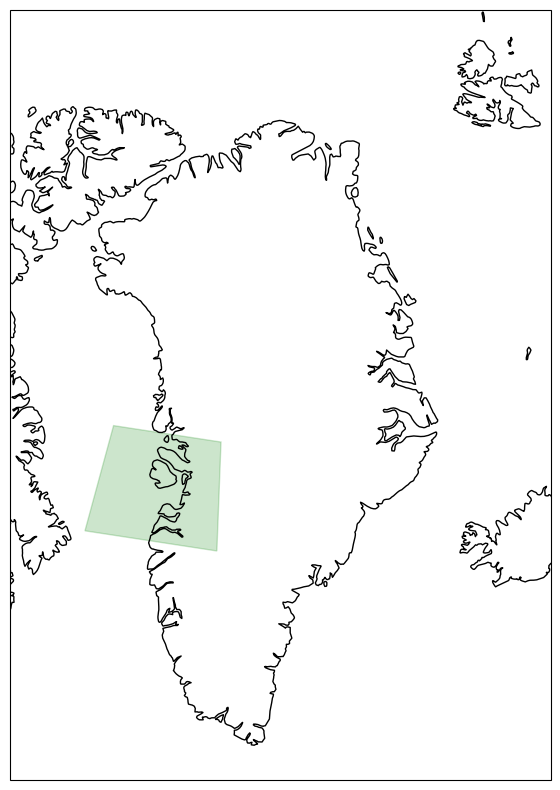

In [35]:
bounding_box = [minx_index, maxx_index, miny_index, maxy_index]
lons, lats = helper.get_lons_lats(bounding_box)
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

helper.plot_polygons(polygons, lons, lats) # plot the polygon on the map

## 4. Get 2019 disko bay data

In [8]:
# firstday, lastday found by trial and error just like the extent indexes 
firstday, lastday = "7763", "8000"      # pt a 
# firstday, lastday = "8001", "8128"    # pt b

url = "https://www.oceancolour.org/thredds/dodsC/CCI_ALL-v6.0-1km-DAILY?lat["+maxy_index+":1:"+miny_index+"],lon["+minx_index+":1:"+maxx_index+"],chlor_a["+firstday+":1:"+lastday+"]["+maxy_index+":1:"+miny_index+"]["+minx_index+":1:"+maxx_index+"],time["+firstday+":1:"+lastday+"]"
ds = nc.Dataset(url)

lats = ds.variables['lat'][:]
lons = ds.variables['lon'][:]
time_var = ds.variables['time'][:]

## 5. Write the data to file

In [10]:
with nc.Dataset('2019_disko_a.nc', 'w') as f:
# with nc.Dataset('2019_disko_b.nc', 'w') as f:
    f.createDimension('time', len(time_var))
    f.createDimension('lat', len(lats))
    f.createDimension('lon', len(lons))

    time_var_out = f.createVariable('time', 'f8', ('time',))
    lat_out = f.createVariable('lat', 'f8', ('lat',))
    lon_out = f.createVariable('lon', 'f8', ('lon',))
    chlor_a_out = f.createVariable('chlor_a', 'f8', ('time', 'lat', 'lon'))

    time_var_out[:] = time_var
    chlor_a_out[:] = ds.variables['chlor_a'][:]
    lat_out[:] = lats
    lon_out[:] = lons